# GitHub-Link
https://github.com/Tschoppsilas/GBSV_2025.git

# Tag 5
## Anwendungsfalls
In traditionellen Schweizer Alpkäsereien lagern Käselaibe auf Holzregalen zur Reifung. Eine automatisierte Erkennung und Zählung dieser Laibe auf Bildern – z.B. aus einer Produktionsüberwachung oder einem Kontrollsystem – kann zur Qualitätskontrolle, Bestandsaufnahme oder Prozessoptimierung beitragen. Besonders in kleinen, handwerklichen Betrieben kann so der Aufwand reduziert und die Nachverfolgbarkeit verbessert werden.

## Problemstellung
Die Käselaibe haben meist eine gleichmässige, runde Form und eine gelblich-bräunliche Färbung, die sich vom Holzregal oder dem dunkleren Reiferaumhintergrund abhebt. Je nach Lichtverhältnissen, Schatten oder teilweiser Überlappung kann die visuelle Trennung jedoch schwierig sein. Ziel ist es, diese gleichartigen Objekte automatisch zu segmentieren, ohne manuelles Zählen. Dies kann insbesondere dann herausfordernd sein, wenn Laibe eng beieinander liegen oder teilweise verdeckt sind.

## Ziel der Segmentierung
Durch die Segmentierung der Käselaibe im Bild soll eine zuverlässige Zählung, Lokalisierung und ggf. Flächenschätzung einzelner Laibe ermöglicht werden. Die daraus gewonnenen Daten können genutzt werden, um Lagerbestände zu automatisieren, Reifeverläufe über Zeiträume zu dokumentieren oder auch visuelle Auffälligkeiten (z.B. Schimmelbildung) frühzeitig zu erkennen – ein praktischer Nutzen für die Lebensmittelüberwachung und das digitale Alpkäsemanagement.

## Bild
Mein Bild, welches ich unten ausgebe, habe ich von folgender Webseite heruntergeladen.
https://www.loisirs.ch/agendas/32860/les-secrets-de-la-fabrication-de-fromage-d-alpage-a-la-poyettaz


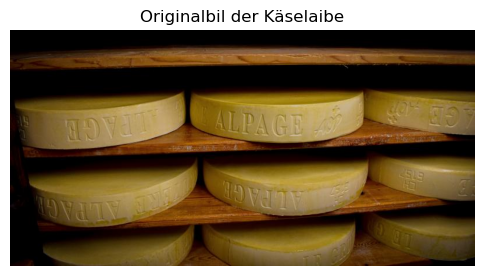

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Bild anzeigen
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Originalbil der Käselaibe")
plt.show()

# Tag 6

Gezählte Käselaibe: 9


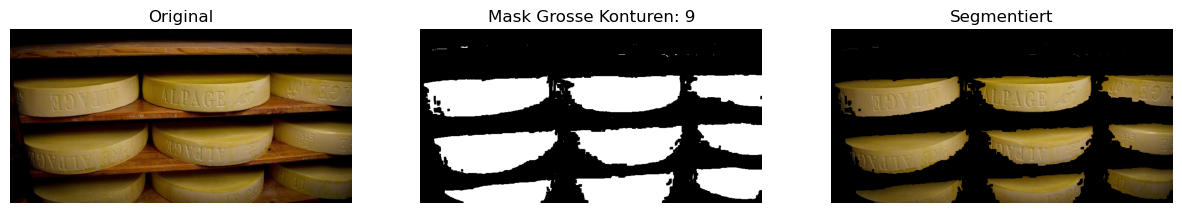

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Bild laden und vorbereiten
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# Farbsegmentierung (LAB)
lower = np.array([40, 110, 0])
upper = np.array([220, 133, 255])
mask = cv2.inRange(lab, lower, upper)

# Maske bereinigen
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Konturen finden und nach Fläche filtern
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 4000
large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# Ergebnis
num_objects = len(large_contours)
print(f"Gezählte Käselaibe: {num_objects}")

# Segmentiertes Bild erstellen
result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_cleaned)

# Visualisierung
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.title("Original"), plt.imshow(img_rgb), plt.axis("off")
plt.subplot(1, 3, 2), plt.title(f"Mask Grosse Konturen: {num_objects}"), plt.imshow(mask_cleaned, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 3), plt.title("Segmentiert"), plt.imshow(result), plt.axis("off")
plt.show()

Die Histogramme zeigen die Verteilung der Farbwerte in den LAB-Kanälen. Daraus lassen sich Schwellenwerte ableiten, um den Farbton der Käselaibe gezielt zu isolieren.


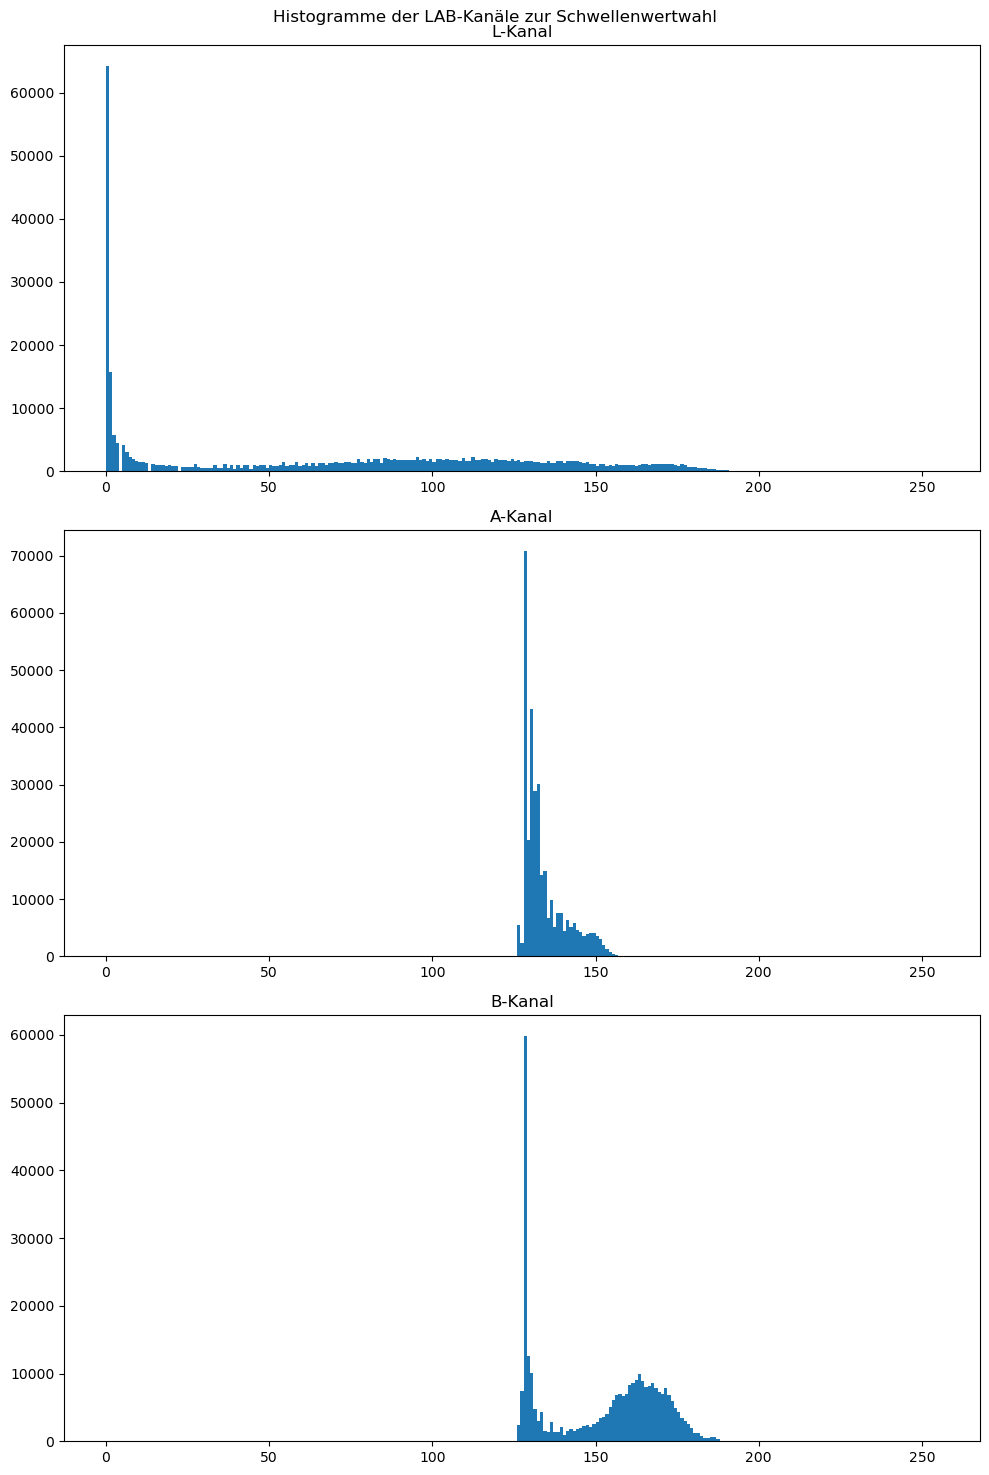

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, a_channel, b_channel = cv2.split(lab)

# Histogramme anzeigen

# Histogramme anzeigen
plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1), plt.hist(l_channel.ravel(), bins=255, range=[0, 255]), plt.title("L-Kanal")
plt.subplot(3, 1, 2), plt.hist(a_channel.ravel(), bins=255, range=[0, 255]), plt.title("A-Kanal")
plt.subplot(3, 1, 3), plt.hist(b_channel.ravel(), bins=255, range=[0, 255]), plt.title("B-Kanal")
plt.suptitle("Histogramme der LAB-Kanäle zur Schwellenwertwahl")
plt.tight_layout()
plt.show()

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Bild laden und vorbereiten
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Rauschreduzierung (angepasste Parameter)
blurred = cv2.medianBlur(gray, 5)  # Besser bei Salz-Pfeffer-Rauschen als GaussianBlur

# 3. Thresholding (Otsu, nicht invertiert!)
_, otsu_mask = cv2.threshold(blurred, 190, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 4. Kleine Störungen entfernen (Rauschen filtern)
kernel = np.ones((3,3), np.uint8)
opened = cv2.morphologyEx(otsu_mask, cv2.MORPH_OPEN, kernel, iterations=3)  # Entfernt kleine weiße Punkte

# 5. Watershed vorbereiten
dist_transform = cv2.distanceTransform(opened, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)  # Marker für Laibe
sure_fg = np.uint8(sure_fg)

# 6. Watershed anwenden
unknown = cv2.subtract(opened, sure_fg)
_, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers[unknown == 0] = 100
markers = cv2.watershed(img, markers)

# 7. Ergebnis extrahieren (Nur Objekte, kein Hintergrund/Rauschen)
final_mask = np.zeros_like(gray, dtype=np.uint8)
final_mask[markers > 1] = 100  # Marker >1 = Käselaibe

# 8. Konturen zählen (nur große Flächen)
contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 500  # Mindestfläche für einen Käselaib (anpassen!)
valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
num_objects = len(valid_contours)
print(f"Gezählte Käselaibe: {num_objects}")

# 9. Visualisierung
colored_labels = np.zeros_like(img)
for i, cnt in enumerate(valid_contours):
    cv2.drawContours(colored_labels, [cnt], 0, (0, 255, 0), 1)  # Grüne Konturen

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1), plt.title("Otsu Mask"), plt.imshow(otsu_mask, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 2), plt.title(f"Finale Maske ({num_objects} Objekte)"), plt.imshow(final_mask, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 3), plt.title("Ergebnis"), plt.imshow(colored_labels), plt.axis("off")
plt.show()

Gezählte Käselaibe: 9


NameError: name 'mask_cleaned' is not defined

# Überarbeitete Version

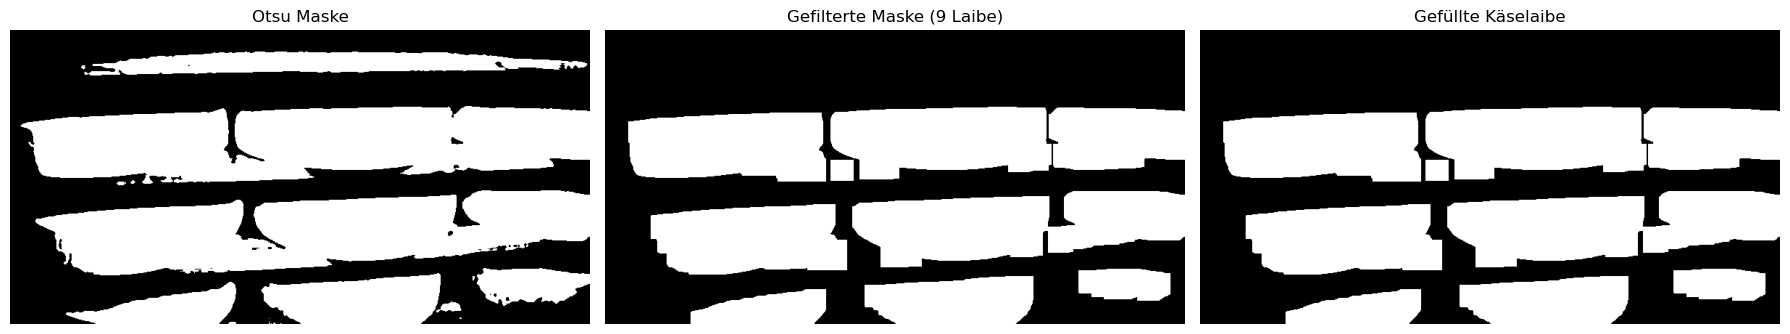

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Bild laden und vorbereiten
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Rauschreduzierung
blurred = cv2.medianBlur(gray, 5)

# 3. Otsu Thresholding (automatisch, nicht invertiert)
_, otsu_mask = cv2.threshold(blurred, 190, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 4. Maske invertieren, wenn nötig (weiße Käselaibe auf dunklem Hintergrund)
# => Hier optional: wenn die Laibe schwarz sind, drehen wir sie um
if np.sum(otsu_mask == 255) > np.sum(otsu_mask == 0):
    otsu_mask = cv2.bitwise_not(otsu_mask)

# 5. Öffnen zum Rauschentfernen
kernel = np.ones((5, 5), np.uint8)
opened = cv2.morphologyEx(otsu_mask, cv2.MORPH_OPEN, kernel, iterations=7)

# 6. Konturen finden
contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 7. Nach Fläche filtern
min_area = 500
valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# 8. Neue Maske mit gefüllten Regionen
filled_mask = np.zeros_like(gray)
cv2.drawContours(filled_mask, valid_contours, -1, 255, thickness=-6)

# 9. Ergebnis anzeigen
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1), plt.title("Otsu Maske"), plt.imshow(otsu_mask, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 2), plt.title(f"Gefilterte Maske ({len(valid_contours)} Laibe)"), plt.imshow(opened, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 3), plt.title("Gefüllte Käselaibe"), plt.imshow(filled_mask, cmap="gray"), plt.axis("off")
plt.tight_layout()
plt.show()


Durch Vergleich der verschiedenen Kernelgrössen wurde festgestellt, dass ein 5x5-Kernel das beste Verhältnis zwischen Glättung und Erhalt feiner Strukturen bietet.

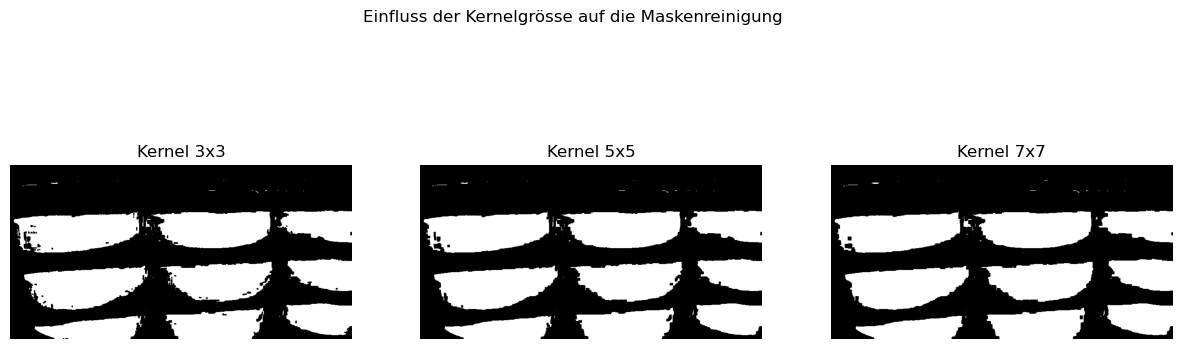

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Bild einlesen und in LAB konvertieren
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# Schwellenwerte für LAB-Farbraum (wie im ursprünglichen Notebook)
lower = np.array([40, 110, 0])
upper = np.array([220, 133, 255])
mask = cv2.inRange(lab, lower, upper)

kernel_sizes = [3, 5, 7]
plt.figure(figsize=(15, 5))
for i, k in enumerate(kernel_sizes):
    kernel = np.ones((k, k), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    plt.subplot(1, len(kernel_sizes), i + 1)
    plt.imshow(cleaned, cmap='gray')
    plt.title(f"Kernel {k}x{k}")
    plt.axis('off')
plt.suptitle("Einfluss der Kernelgrösse auf die Maskenreinigung")
plt.show()

Diese Grafik zeigt, wie sich die Mindestfläche auf die Objektanzahl auswirkt. Bei 1000 px wurde der letzte runde Wert gefunden, welcher noch alle 9 Käse erkennt

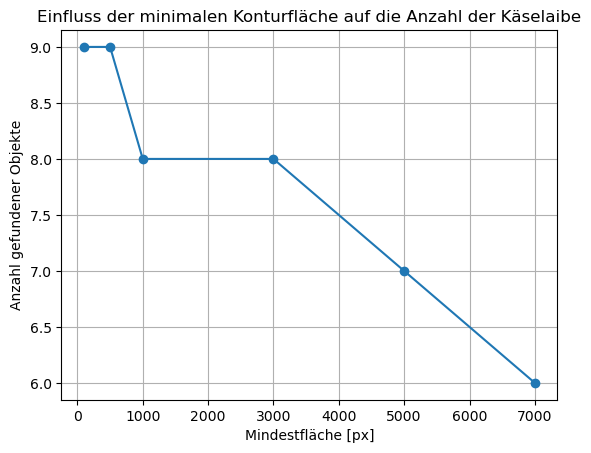

In [48]:
areas = [100, 500, 1000, 3000, 5000, 7000]
counts = []

for min_area in areas:
    filtered = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    counts.append(len(filtered))

plt.figure()
plt.plot(areas, counts, marker='o')
plt.title("Einfluss der minimalen Konturfläche auf die Anzahl der Käselaibe")
plt.xlabel("Mindestfläche [px]")
plt.ylabel("Anzahl gefundener Objekte")
plt.grid(True)
plt.show()

# Tag 7

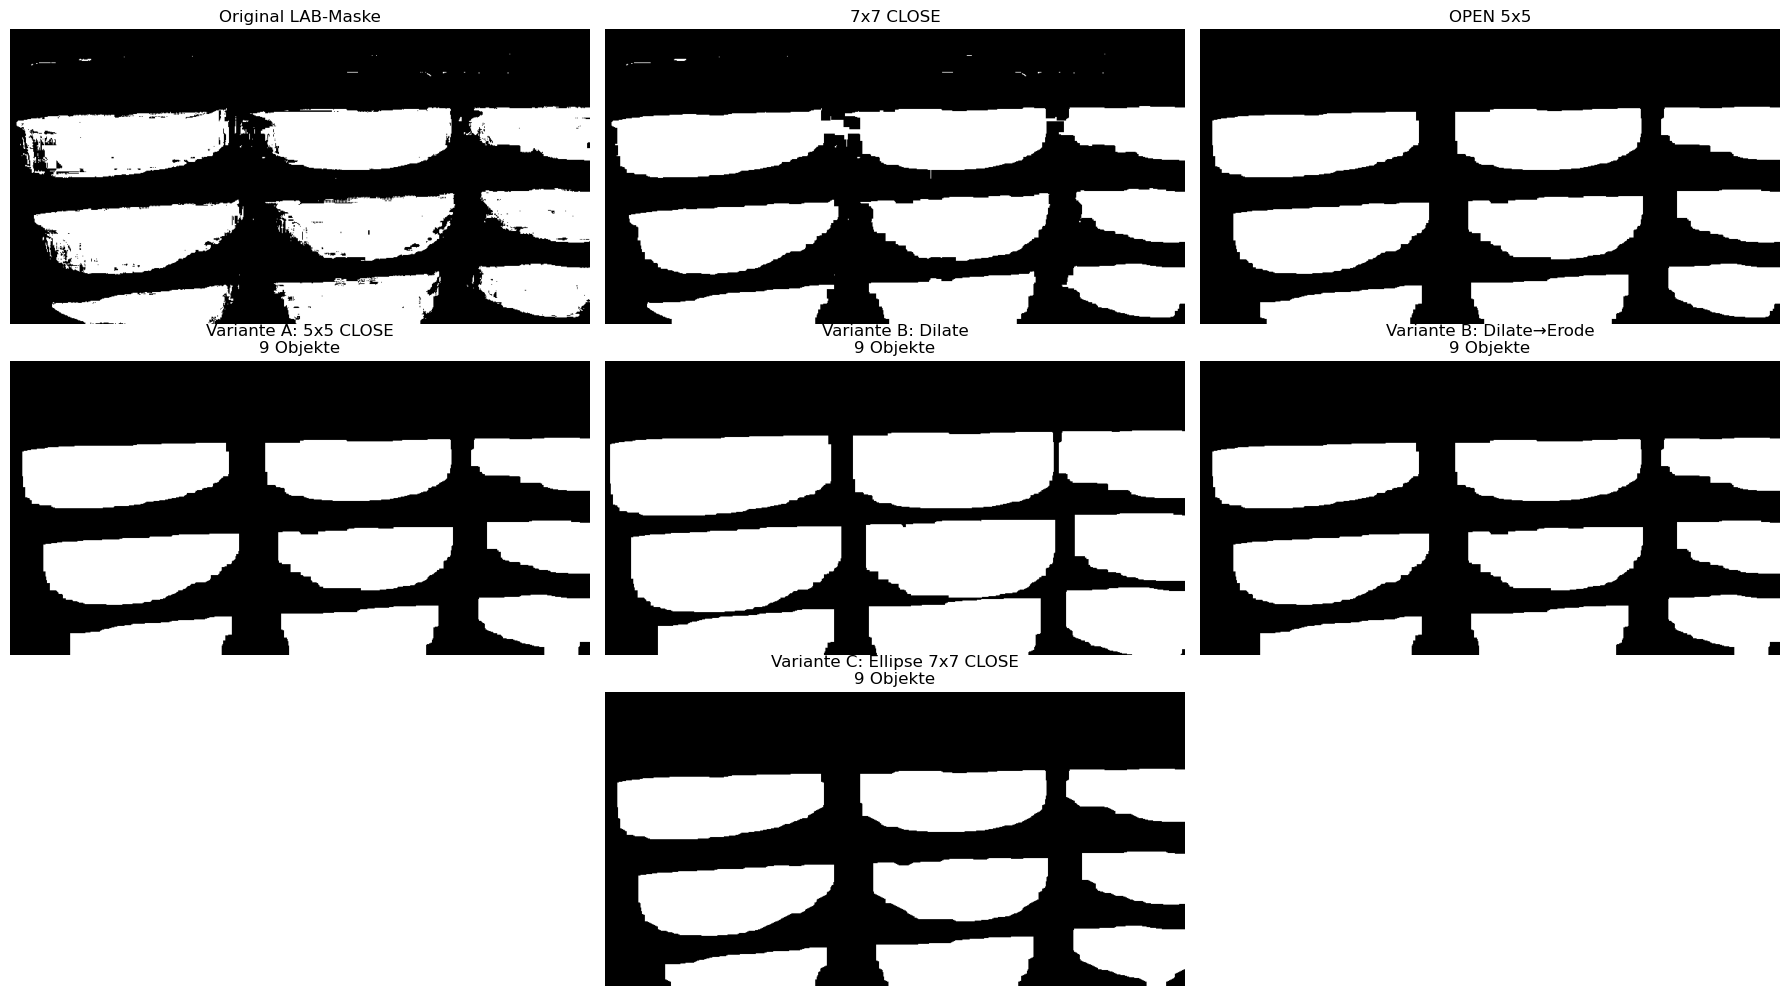

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Bild laden und in verschiedene Farbräume umwandeln
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# LAB-Segmentierung
lower = np.array([40, 110, 0])
upper = np.array([220, 133, 255])
mask = cv2.inRange(lab, lower, upper)

# ---------------- Morphologische Operationen ----------------

# Schritt 1: Grobes Closing mit 7x7 (füllt grosse Lücken)
kernel_large = np.ones((7, 7), np.uint8)
mask_close5 = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_large, iterations=2)

# Schritt 2: Fein-Öffnen mit 5x5 (entfernt kleine weisse Flecken)
kernel_small = np.ones((5, 5), np.uint8)
mask_open = cv2.morphologyEx(mask_close5, cv2.MORPH_OPEN, kernel_small, iterations=5)

# Variante A: Finales Closing mit 3x3 (sanfte Lückenfüllung)
mask_refined_A = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel_small, iterations=5)

# Variante B: Alternativ mit Dilate → Erode
mask_dilated = cv2.dilate(mask_open, kernel_small, iterations=5)
mask_refined_B = cv2.erode(mask_dilated, kernel_small, iterations=5)

# Variante C: Elliptischer Kernel für rundere Lücken
kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_refined_C = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel_ellipse, iterations=5)

# ---------------- Konturen zählen ----------------

def count_objects(mask, min_area=4000):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    large = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    return len(large)

nA = count_objects(mask_refined_A)
nB = count_objects(mask_refined_B)
nC = count_objects(mask_refined_C)

# ---------------- Visualisierung ----------------

plt.figure(figsize=(18, 10))
plt.subplot(3, 3, 1), plt.title("Original LAB-Maske"), plt.imshow(mask, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 2), plt.title("7x7 CLOSE"), plt.imshow(mask_close5, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 3), plt.title("OPEN 5x5"), plt.imshow(mask_open, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 4), plt.title(f"Variante A: 5x5 CLOSE\n{nA} Objekte"), plt.imshow(mask_refined_A, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 5), plt.title(f"Variante B: Dilate\n{nB} Objekte"), plt.imshow(mask_dilated, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 6), plt.title(f"Variante B: Dilate→Erode\n{nB} Objekte"), plt.imshow(mask_refined_B, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 8), plt.title(f"Variante C: Ellipse 7x7 CLOSE\n{nC} Objekte"), plt.imshow(mask_refined_C, cmap="gray"), plt.axis("off")
plt.tight_layout()
plt.show()

## Auswahl der Kernelgrössen (5×5 und 7×7) für Morphologische Operationen
Um die Segmentierungsergebnisse zu verbessern, habe ich verschiedene Kernelgrössen für die morphologische Schliessung (Closing) getestet: 3×3, 5×5 und 7×7.

Dabei zeigte sich:

3×3: Schliesst kleine Lücken unzureichend. Die Konturen bleiben unruhig und einzelne Objekte wirken fragmentiert.

5×5: Liefert deutlich glattere und vollständigere Masken. Kleine Lücken werden geschlossen, ohne dass benachbarte Objekte verschmelzen.

7×7: Führt zu einer noch glatteren Objektform. Die Masken sind besonders sauber und zusammenhängend, ohne visuelles Rauschen. Die Objektform bleibt dabei weitgehend erhalten.

### Entscheidungskriterium:
Ich habe mich bewusst für die Kombination von 5×5 und 7×7 entschieden, da beide zu einem visuell sehr sauberen Endresultat führen. Die Objektkonturen sind glatt, geschlossen und ohne störendes Rauschen. Besonders mit 7×7 war das Ergebnis am einheitlichsten und am besten für eine spätere Zählung geeignet.

Diese Wahl basiert auf einer systematischen visuellen Analyse, bei der ich den Einfluss der Kernelgrösse auf die Qualität der Segmentierungsmaske direkt verglichen habe.

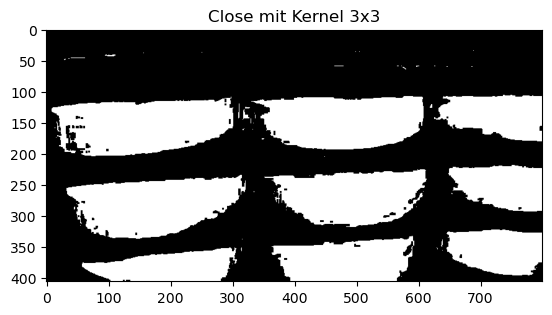

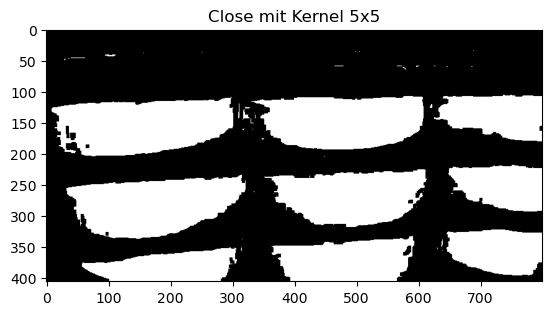

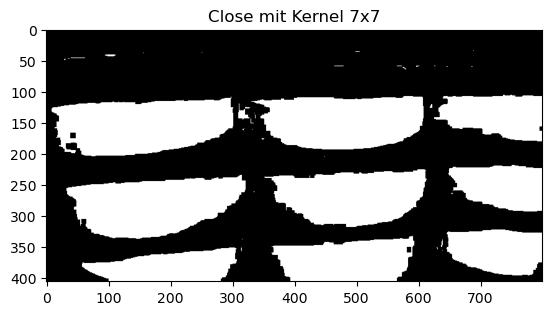

In [2]:
for size in [3, 5, 7]:
    kernel = np.ones((size, size), np.uint8)
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    plt.imshow(mask_closed, cmap="gray")
    plt.title(f"Close mit Kernel {size}x{size}")
    plt.show()

# Tag 8

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Maske von Tag 7 laden (Variante A als beste)
mask = mask_refined_A.copy()

# Konturen extrahieren
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Merkmale extrahieren
areas = []
perimeters = []
orientations = []

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 4000:  # Filter beibehalten
        continue

    perimeter = cv2.arcLength(cnt, True)
    M = cv2.moments(cnt)
    
    # Orientierung berechnen (in Grad)
    if M["m00"] != 0:
        orientation = 0.5 * np.arctan2(2*M["mu11"], (M["mu20"] - M["mu02"])) * (180 / np.pi)
    else:
        orientation = 0

    areas.append(area)
    perimeters.append(perimeter)
    orientations.append(orientation)

# Anzahl
print(f"Anzahl Käselaibe: {len(areas)}")

Anzahl Käselaibe: 9


Fläche: Mittel=13928.4, Std=4856.3
Umfang: Mittel=575.8, Std=107.7
Orientierung: Mittel=0.2°, Std=4.9°


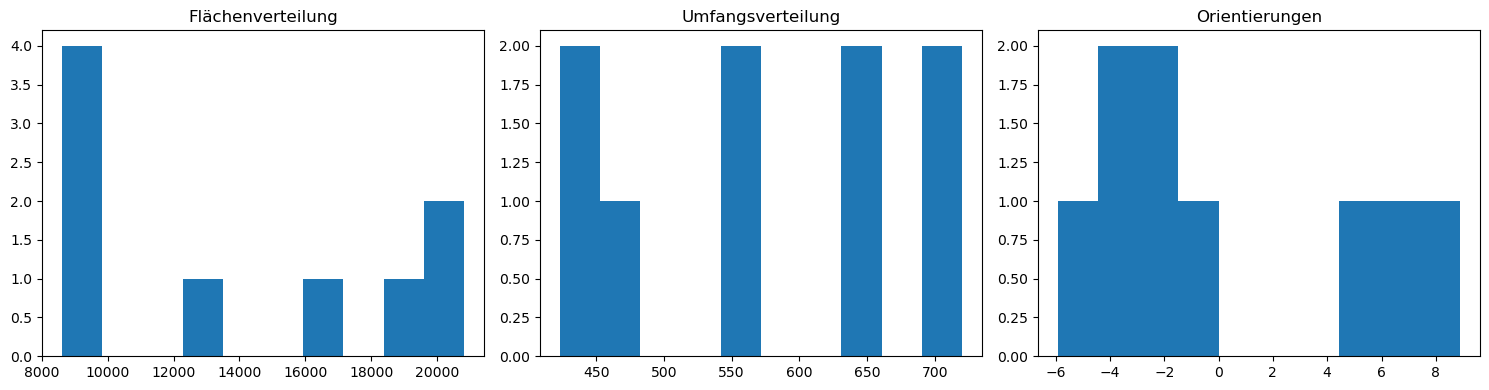

In [6]:
# Statistische Auswertung mit beschrifteten Achsen und besserem Layout
print(f"Fläche: Mittel={np.mean(areas):.1f}, Std={np.std(areas):.1f}")
print(f"Umfang: Mittel={np.mean(perimeters):.1f}, Std={np.std(perimeters):.1f}")
print(f"Orientierung: Mittel={np.mean(orientations):.1f}°, Std={np.std(orientations):.1f}°")

plt.figure(figsize=(15, 4))

# Flächenverteilung
plt.subplot(1, 3, 1)
plt.hist(areas, bins=10, color='skyblue', edgecolor='black')
plt.title("Flächenverteilung")
plt.xlabel("Fläche (Pixel)")
plt.ylabel("Anzahl Objekte")

# Umfangsverteilung
plt.subplot(1, 3, 2)
plt.hist(perimeters, bins=10, color='lightgreen', edgecolor='black')
plt.title("Umfangsverteilung")
plt.xlabel("Umfang (Pixel)")
plt.ylabel("Anzahl Objekte")

# Orientierungsverteilung
plt.subplot(1, 3, 3)
plt.hist(orientations, bins=10, color='salmon', edgecolor='black')
plt.title("Orientierungsverteilung")
plt.xlabel("Orientierung (Radiant)")
plt.ylabel("Anzahl Objekte")

plt.tight_layout()
plt.show()

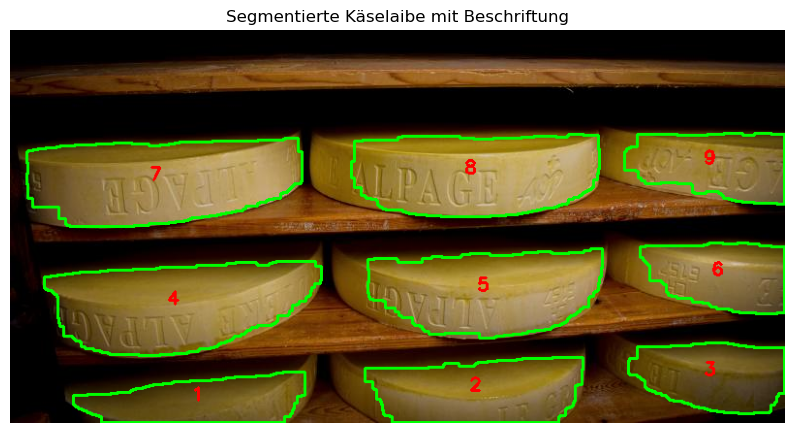

In [7]:
output = img_rgb.copy()

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    if area < 4000:
        continue

    M = cv2.moments(cnt)
    if M["m00"] == 0:
        continue
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    cv2.drawContours(output, [cnt], -1, (0, 255, 0), 2)
    cv2.putText(output, f"{i+1}", (cx - 10, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(10, 8))
plt.title("Segmentierte Käselaibe mit Beschriftung")
plt.imshow(output)
plt.axis("off")
plt.show()


# Tag 9

Anzahl der Skelett-Pixel: 2384


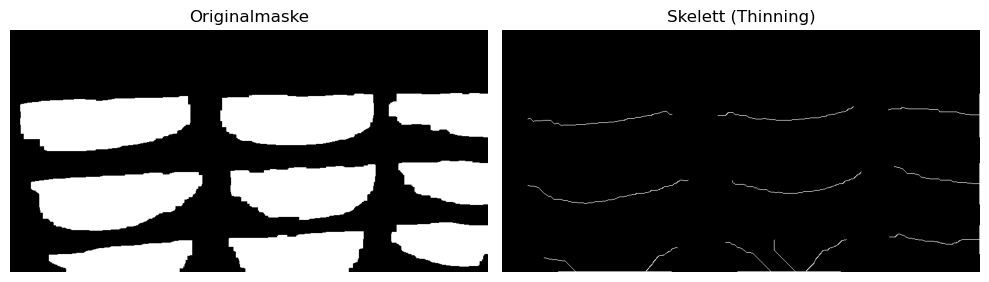

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Schritt 1: Maske laden oder verwenden
mask = mask_refined_A.copy()  # Deine vorbereitete Objektmaske (z. B. aus Segmentierung)

# Schritt 2: Binärmaske erzeugen
binary_mask = (mask > 0).astype(np.uint8) * 255  # Umwandlung in uint8 für OpenCV

# Schritt 3: Skeletonisierung per Thinning (OpenCV-Erweiterung)
# Prüfen, ob ximgproc verfügbar ist
try:
    from cv2.ximgproc import thinning
except ImportError:
    raise ImportError("Modul 'cv2.ximgproc' ist nicht installiert. Installiere OpenCV mit Extra-Modulen: pip install opencv-contrib-python")

skeleton = thinning(binary_mask)

# Schritt 4: Pixel zählen
num_skeleton_pixels = cv2.countNonZero(skeleton)
print(f"Anzahl der Skelett-Pixel: {num_skeleton_pixels}")

# Schritt 5: Visualisierung
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Originalmaske")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Skelett (Thinning)")
plt.imshow(skeleton, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

# Tag 10
Zur Segmentierung der Käselaibe habe ich zunächst ein Schwellwertverfahren verwendet, um eine binäre Trennung von Vorder- und Hintergrund zu erreichen. Die Wahl des Schwellwerts erfolgte experimentell, um eine möglichst genaue Extraktion der Objekte zu erzielen. Anschliessend wurden morphologische Operationen wie Erosion und Dilatation eingesetzt, um Bildrauschen zu entfernen sowie angrenzende Laibe zu separieren.

Die gewählte Methode liefert klare und nachvollziehbare Resultate: Die Käselaibe konnten gut segmentiert und kleinere Artefakte entfernt werden. Dadurch konnte die Qualität der Analyse verbessert werden. Zusätzlich wurden objektbasierte Merkmale wie Fläche und Umfang berechnet, die für weitere Analysen wie Qualitätskontrolle relevant sein könnten.

Ein kritischer Aspekt ist die Abhängigkeit der Segmentierung von den Lichtverhältnissen und dem Kontrast. In stark beleuchteten oder überschatteten Bereichen kann die Methode versagen. Auch die Perspektive spielt eine Rolle: Eine frontale Aufnahme sowie ein Regal mit kontrastreicher Farbe (anstelle von Holz) könnten die Segmentierung wesentlich erleichtern. In Zukunft könnten adaptive Verfahren oder Deep-Learning-Ansätze robuster sein.